# Quick analyzer of wether an object is visible from OT and when
Write object name, RA and DEC.

In [55]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import get_sun
from astropy.coordinates import Angle
from astropy.time import Time
import astropy.units as u
import datetime

In [63]:
# String with object name
obj_name = 'QSO0957+561'
# RA in selected units
RA_hh_mm_ss = '10 01 20.069190 hours'  # hour, min, sec
# [10 ,1, 20.69190]
# RA_hh = 
DEC_dd_mm_ss = '+55 53 55.5939 deg' # deg, arcmin, arcsec

init_start_date = True #'2025-01-01' # if true, start date is today. If not true, insert string with YYYY-MM-DD for start date

n_days = 625  # more than one year



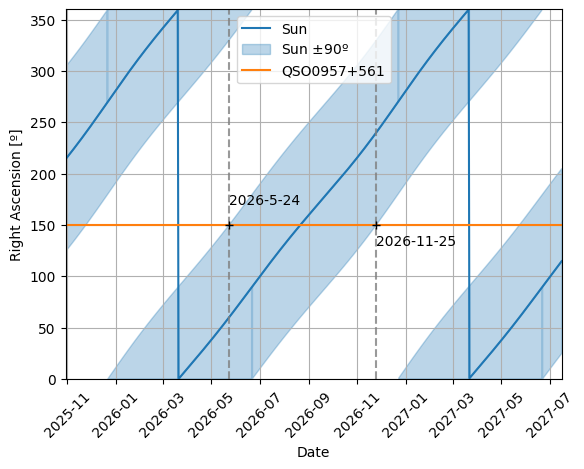

In [65]:
# --- Configuration ---
if init_start_date == True: start_date = datetime.date.today()
else: start_date = datetime.date.fromisoformat(init_start_date)

# Create list of datetime.datetime objects (midnight UTC)
datetimes = [
    datetime.datetime.combine(start_date + datetime.timedelta(days=i), datetime.time(0, 0))
    for i in range(n_days)
]

# Convert to Astropy Time objects
times = Time(datetimes)

# Compute the Sun's coordinates for each date
sun_coords = get_sun(times)

# Convert input RA and DEC to angle
obj_RA = Angle(RA_hh_mm_ss).to(u.deg)
obj_DEC = Angle(DEC_dd_mm_ss)


# RA as continuous
sun_ra_cont = sun_coords.ra.copy()
i_0 = np.argmin(sun_ra_cont)
offset = np.concatenate((np.zeros(i_0), np.ones(int(n_days-i_0))))

sun_ra_cont = sun_ra_cont #+ offset * 360 * u.deg
sun_ra_cont_offset = sun_ra_cont + offset * 360 * u.deg

# DESI_ra = np.ones(n_days)*350.4458*u.deg
obj_RA_array = obj_RA * np.ones(n_days)

i_up_above = np.where(sun_ra_cont+90*u.deg>360*u.deg, 1, 0)
i_up_below = 1-i_up_above
i_lo_below = np.where(sun_ra_cont-90*u.deg < 0*u.deg, 1, 0)
i_lo_above = 1-i_lo_below

up_bound = sun_ra_cont+90*u.deg - 360*u.deg*i_up_above
lo_bound = sun_ra_cont-90*u.deg + 360*u.deg*i_lo_below

i_up_good = np.where(up_bound>sun_ra_cont, 0,1)
i_lo_good = np.where(lo_bound<sun_ra_cont, 0,1)
#index of times in which object appears and disappears
i_1 = np.argmin(abs(up_bound - obj_RA))
i_2 = np.argmin(abs(lo_bound - obj_RA))

# plotting
fig, ax = plt.subplots(num =1)

ax.plot(times.datetime, sun_ra_cont, color = 'tab:blue', label = 'Sun')

ax.fill_between(np.ma.array(times.datetime, mask = i_lo_good),
                np.ma.array((lo_bound).value, mask= i_lo_good), 
                sun_ra_cont.value, alpha = 0.3, color = 'tab:blue', label = 'Sun $\\pm 90$º')
ax.fill_between(np.ma.array(times.datetime, mask = 1-i_lo_good), 
                np.ma.array((lo_bound).value, mask= 1-i_lo_good), 
                360, alpha = 0.3, color = 'tab:blue')

ax.fill_between(np.ma.array(times.datetime, mask = i_up_good), 
                sun_ra_cont.value, 
                np.ma.array((up_bound).value, mask= i_up_good), alpha = 0.3, color = 'tab:blue')
ax.fill_between(np.ma.array(times.datetime, mask = 1-i_up_good),
                0,  
                np.ma.array((up_bound).value, mask= 1-i_up_good), alpha = 0.3, color = 'tab:blue')

ax.fill_between(np.ma.array(times.datetime, mask = 1-(1-i_up_good)*i_lo_good),
                0,
                sun_ra_cont.value, alpha = 0.3, color = 'tab:blue')
ax.fill_between(np.ma.array(times.datetime, mask = 1-(1-i_lo_good)*i_up_good),
                sun_ra_cont.value, 
                360, alpha = 0.3, color = 'tab:blue')

ax.plot(times.datetime, obj_RA_array, color = 'tab:orange', label = obj_name) 


ax.axvline(times.datetime[i_1], ls='dashed', color='gray', alpha =0.8)
ax.axvline(times.datetime[i_2], ls='dashed', color='gray', alpha =0.8)
ax.plot(times.datetime[i_1],  obj_RA_array[0].value, marker='+', color ='black')
ax.plot(times.datetime[i_2],  obj_RA_array[0].value, marker='+', color ='black')
ax.text(times.datetime[i_1],  obj_RA_array[0].value+20, str(times.datetime[i_1].year)+'-'+str(times.datetime[i_1].month)+'-'+str(times.datetime[i_1].day))
ax.text(times.datetime[i_2],  obj_RA_array[0].value-20, str(times.datetime[i_2].year)+'-'+str(times.datetime[i_2].month)+'-'+str(times.datetime[i_2].day))

ax.set_xlabel('Date')
ax.set_ylabel('Right Ascension [º]')
ax.set_xlim(times.datetime[0], times.datetime[-1])
ax.set_ylim(0,360)
ax.tick_params('x', rotation = 45)
ax.grid()
ax.legend()
plt.savefig('observation'+obj_name+'.png', dpi=200)
